# Downloading and Importing dataset.

## Installing dependencies

In [2]:
!pip install datasets

In [3]:
! pip install indic-transliteration

## Importing Libraries.

In [51]:
from datasets import load_dataset
import re
import transformers
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, AdamWeightDecay, Seq2SeqTrainer
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate
from transformers import TrainingArguments
from transformers import Trainer

## Loading dataset.

Loading the dataset.

In [7]:
data = load_dataset("SKNahin/bengali-transliteration-data")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
data

DatasetDict({
    train: Dataset({
        features: ['bn', 'rm'],
        num_rows: 5006
    })
})

## Splitting the dataset into `training` split and `validation` split.

In [9]:
# Spliting the training dataset into 80% train and 20% validation
split_data = data['train'].train_test_split(test_size=0.2, seed=42)

# Accessing the train and validation datasets
train_data = split_data['train']
validation_data = split_data['test']

# Printing information about the splits
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(validation_data)} samples")

Training set: 4004 samples
Validation set: 1002 samples


In [10]:
train_data[:5]

{'bn': ['এটা কোনো পোস্ট হলো মিয়া আবাল',
  'ডিলিট করেন পোস্ট…',
  'জি ভাই অসাধারণ হইছে বাট ফুল ডিটেইলস জানতে পারলাম না, আর এটা কি বিডি তে সব জায়গাতেই পাওয়া যাবে?',
  'ভাই...আর ২৪ আওয়ার ওয়েট করেন..আমার এফবি আইডি ব্যাক আসবে আমি রিকুয়েস্ট পাঠায়া দিছি...',
  'এক সাথে কয়টা একাউন্ট লগইন করে রাখা যায় ব্রো?'],
 'rm': ['eta kono post holo mia abal',
  'Delete koren post…',
  'ji bai osadaron hoice but full detailes janty parlam na, r eta ki bd te sob jaygatei powa jabe?',
  'vai…ar 24 hour wait koren..amar fb id back ashbe ami request pathaia disi…',
  'Ak sathe koyta account login kre rakha jay bro?']}

In [11]:
validation_data[:5]

{'bn': ['ভালো করে ট্রাই করেন পাবেন..',
  'এতো বানান ভুল করছেন বারে ',
  'যা শুরু করছেন ভাই?',
  'মাশাল্লাহ অনেক সুন্দর পোষ্ট।',
  'এতো কিছুর দরকার হয় না… জাস্ট মডিউল ফ্ল্যাশ ইজ এনাফ… আর এই সিস্টেম এ অন্য ইমজি মারলে ফেইসবুক, মেসেঞ্জার ওদের নিজেদের ইমজিই শো করবে '],
 'rm': ['valo kore trai koren paben..',
  'Eto banan vul krcen bare',
  'ja suru korcen vai?',
  'masallha onak sundor post.',
  'eto kisur dorkar hoy nah… just module flash is enough… r ei system e onno emoji marle Facebook, messenger oder nijeder emojiii show korbe']}

# Data Preprocessing.

We can do these following steps inorder to do data preprocessing:
1. Lowercasing
2. Removing Punctuation & Special Characters
3. Stop-Words Removal(not required for this dataset.)
4. Removal of URLs(not required for this dataset.)
5. Removal of HTML Tags(not required for this dataset.)
6. Stemming & Lemmatization(not required for this dataset.)
7. Tokenization
8. Text Normalization

## Converting into `lowercase` and removing `leading and trailing spaces`.

In [12]:
def clean_text(text):
    text = text.strip()  # Remove leading/trailing spaces
    text = text.lower()  # Convert to lowercase
    return text

# Apply to both 'bn' and 'rm' columns
train_data = train_data.map(lambda x: {'bn': clean_text(x['bn']), 'rm': clean_text(x['rm'])})
validation_data = validation_data.map(lambda x: {'bn': clean_text(x['bn']), 'rm': clean_text(x['rm'])})

In [13]:
train_data[:5]

{'bn': ['এটা কোনো পোস্ট হলো মিয়া আবাল',
  'ডিলিট করেন পোস্ট…',
  'জি ভাই অসাধারণ হইছে বাট ফুল ডিটেইলস জানতে পারলাম না, আর এটা কি বিডি তে সব জায়গাতেই পাওয়া যাবে?',
  'ভাই...আর ২৪ আওয়ার ওয়েট করেন..আমার এফবি আইডি ব্যাক আসবে আমি রিকুয়েস্ট পাঠায়া দিছি...',
  'এক সাথে কয়টা একাউন্ট লগইন করে রাখা যায় ব্রো?'],
 'rm': ['eta kono post holo mia abal',
  'delete koren post…',
  'ji bai osadaron hoice but full detailes janty parlam na, r eta ki bd te sob jaygatei powa jabe?',
  'vai…ar 24 hour wait koren..amar fb id back ashbe ami request pathaia disi…',
  'ak sathe koyta account login kre rakha jay bro?']}

## Removing `Punctuations` and `Special Characters`

In [14]:
def remove_punctuation_except_question_mark(text):
    # Defining a regex pattern to remove all non-alphanumeric characters except spaces and '?'
    pattern = r'[^a-zA-Z0-9\s?০-৯আ-হঅ-ঔঋ-ৠ]+'
    return re.sub(pattern, '', text)

# Applying the function to both 'bn' and 'rm' columns in the dataset
train_data = train_data.map(lambda x: {
    'bn': remove_punctuation_except_question_mark(x['bn']),
    'rm': remove_punctuation_except_question_mark(x['rm'])
})

validation_data = validation_data.map(lambda x: {
    'bn': remove_punctuation_except_question_mark(x['bn']),
    'rm': remove_punctuation_except_question_mark(x['rm'])
})


## Checking the distribution of the dataset.

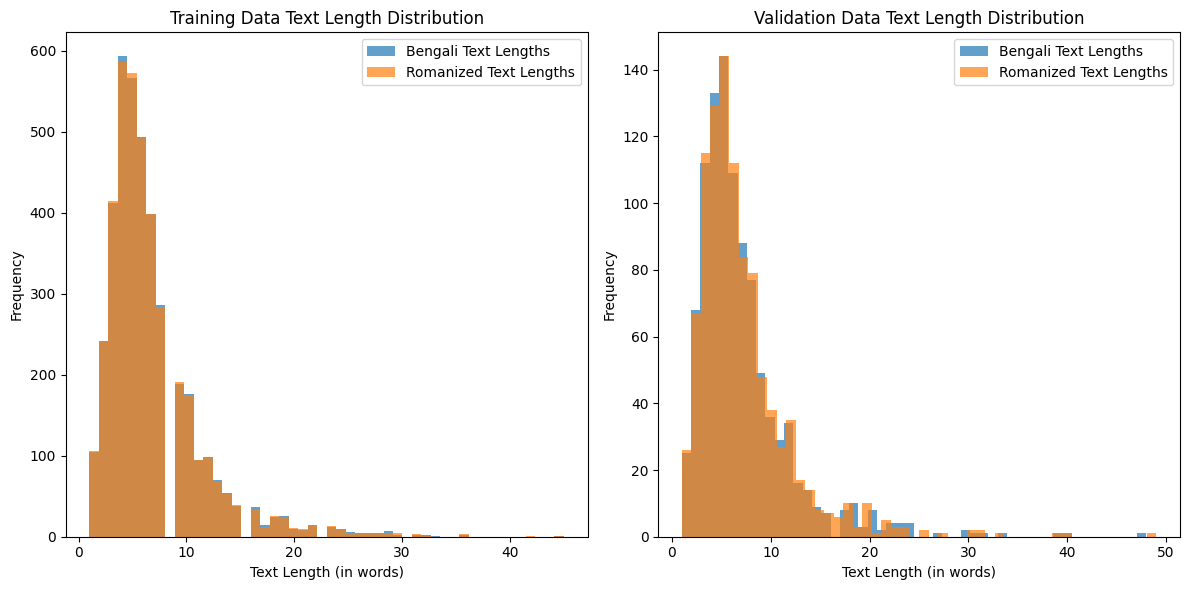

Max Bengali Text Length in Training Data: 45
Max Romanized Text Length in Training Data: 45
Indexes of long Bengali texts ( > 100 words): []
Indexes of long Romanized texts ( > 100 words): []


In [15]:
import matplotlib.pyplot as plt

# Function to compute text length
def compute_length(text):
    return len(text.split())  # You can change this to len(text) for character length

# Compute lengths for both 'bn' and 'rm' columns in training and validation datasets
train_data = train_data.map(lambda x: {
    'bn_length': compute_length(x['bn']),
    'rm_length': compute_length(x['rm'])
})

validation_data = validation_data.map(lambda x: {
    'bn_length': compute_length(x['bn']),
    'rm_length': compute_length(x['rm'])
})

# Now let's plot the distribution of lengths
train_bn_lengths = [len_['bn_length'] for len_ in train_data]
train_rm_lengths = [len_['rm_length'] for len_ in train_data]

validation_bn_lengths = [len_['bn_length'] for len_ in validation_data]
validation_rm_lengths = [len_['rm_length'] for len_ in validation_data]

# Plotting histograms to visualize text length distribution
plt.figure(figsize=(12, 6))

# Training data
plt.subplot(1, 2, 1)
plt.hist(train_bn_lengths, bins=50, alpha=0.7, label='Bengali Text Lengths')
plt.hist(train_rm_lengths, bins=50, alpha=0.7, label='Romanized Text Lengths')
plt.title('Training Data Text Length Distribution')
plt.xlabel('Text Length (in words)')
plt.ylabel('Frequency')
plt.legend()

# Validation data
plt.subplot(1, 2, 2)
plt.hist(validation_bn_lengths, bins=50, alpha=0.7, label='Bengali Text Lengths')
plt.hist(validation_rm_lengths, bins=50, alpha=0.7, label='Romanized Text Lengths')
plt.title('Validation Data Text Length Distribution')
plt.xlabel('Text Length (in words)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Optionally, identify long entries in the datasets
max_train_bn_length = max(train_bn_lengths)
max_train_rm_length = max(train_rm_lengths)

print(f'Max Bengali Text Length in Training Data: {max_train_bn_length}')
print(f'Max Romanized Text Length in Training Data: {max_train_rm_length}')

# Checking if any text exceeds a reasonable length threshold.
long_train_bn = [i for i, length in enumerate(train_bn_lengths) if length > 100]
long_train_rm = [i for i, length in enumerate(train_rm_lengths) if length > 100]

print(f'Indexes of long Bengali texts ( > 100 words): {long_train_bn}')
print(f'Indexes of long Romanized texts ( > 100 words): {long_train_rm}')

## Tokenizing.

In [16]:
# Initialize a pre-trained (BERT multilingual) tokenizer.
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

In [17]:
def tokenize_data(batch):
    return tokenizer(batch['bn'], text_pair=batch['rm'], padding="max_length", truncation=True, max_length=128)

# Apply tokenization to both training and validation datasets
train_data = train_data.map(tokenize_data, batched=True)
validation_data = validation_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

In [18]:
tokenizer('website theke download disi app not installed dekhai..help plz')

{'input_ids': [101, 13575, 10105, 10550, 13737, 27920, 10116, 72894, 10472, 34398, 18910, 37821, 119, 119, 15217, 20648, 10305, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
tokenizer('dite hobe na','Doctor er poramorsho nieya uchit jekono osudh khwar somoy.')

{'input_ids': [101, 44586, 13173, 11044, 10132, 102, 17376, 10163, 10183, 39884, 10943, 10758, 11058, 10679, 189, 12806, 10123, 10144, 17423, 10133, 10427, 11679, 10237, 179, 77155, 10129, 10181, 20712, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

We converted sentences into numbers now...

In [20]:
with tokenizer.as_target_tokenizer():
  print(tokenizer(['এক্সপ্লোরার গুগল সার্চ করুন']))

{'input_ids': [[101, 28777, 27556, 22335, 111240, 105864, 98655, 950, 16166, 20725, 13458, 978, 15010, 111240, 39427, 948, 11128, 64437, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Since we our goal is to translate from `banglish` to `bangla`. Our target is `bangla` and source is `banglish`. So we use `as_target_tokenizer` on `bangla`.  

In [21]:
def preprocess_data(batch):
    # Convert target text to labels
    batch["labels"] = batch["input_ids"]  # Use the input_ids for labels
    return batch

# Apply the preprocessing function
train_data = train_data.map(preprocess_data, batched=True)
validation_data = validation_data.map(preprocess_data, batched=True)

Map:   0%|          | 0/4004 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

In [49]:
# Check a few examples from the dataset
print(train_data[0])
print(validation_data[0])

{'bn': 'এটা কোনো পোস্ট হলো মিয়া আবাল', 'rm': 'eta kono post holo mia abal', 'bn_length': 6, 'rm_length': 6, 'input_ids': [101, 944, 36715, 77001, 968, 16431, 71482, 96135, 100, 938, 56078, 13458, 102, 10408, 18840, 10133, 11841, 110516, 10133, 44555, 11357, 10415, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention

# Initializing the model.

## Loading Pretrained models.

In [52]:
from transformers import MBartForConditionalGeneration, MBartTokenizer

# Load the model and tokenizer for mBART (multilingual model)
model_name = "facebook/mbart-large-50-many-to-many-mmt"
model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer = MBartTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


In [54]:
def preprocess_data(batch):
    inputs = tokenizer(batch["rm"], padding=True, truncation=True, max_length=128, return_tensors="pt")

    targets = tokenizer(batch["bn"], padding=True, truncation=True, max_length=128, return_tensors="pt")

    batch["input_ids"] = inputs["input_ids"]
    batch["attention_mask"] = inputs["attention_mask"]
    batch["labels"] = targets["input_ids"]

    batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in batch["labels"]]

    return batch

train_data = train_data.map(preprocess_data, batched=True)
validation_data = validation_data.map(preprocess_data, batched=True)

Map:   0%|          | 0/4004 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

In [58]:
# Updated Training Arguments
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save results
    eval_strategy="epoch",               # Replaced evaluation_strategy with eval_strategy
    learning_rate=2e-5,                  # Learning rate (you can tune this)
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=16,       # Batch size for evaluation
    num_train_epochs=3,                  # Number of epochs
    weight_decay=0.01,                   # Weight decay for regularization
    logging_dir="./logs",                # Directory for logs
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    processing_class=tokenizer,  # Replaced tokenizer with processing_class
)


In [61]:
trainer.train()

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`labels` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [62]:
trainer.evaluate(validation_data)


Epoch,Training Loss,Validation Loss


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`labels` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [63]:
def translate(text):
    # Prepare the text for translation
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Generate translation
    translated_tokens = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"])

    # Decode the translated text
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

# Example usage
translated_sentence = translate("This is a test sentence.")
print(translated_sentence)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)